In [ ]:
# Big Data Scaling Final Project
# Sunspot Prediction using Time Series Libraries

In [ ]:
# This approach did not work, but I am including the code for reference

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pandas as pd
import numpy as np

In [2]:
spark = SparkSession.builder.master("local[4]").appName("sunspots").getOrCreate()

In [4]:
!pwd

/


In [3]:
# Read data
df = spark.read.csv("hdfs://cluster-bigdata1-m/user/dataproc/sunspots.csv", header=True, inferSchema=True)
df.show()

+---+-------------------+---------------------------------+
|_c0|               Date|Monthly Mean Total Sunspot Number|
+---+-------------------+---------------------------------+
|  0|1749-01-31 00:00:00|                             96.7|
|  1|1749-02-28 00:00:00|                            104.3|
|  2|1749-03-31 00:00:00|                            116.7|
|  3|1749-04-30 00:00:00|                             92.8|
|  4|1749-05-31 00:00:00|                            141.7|
|  5|1749-06-30 00:00:00|                            139.2|
|  6|1749-07-31 00:00:00|                            158.0|
|  7|1749-08-31 00:00:00|                            110.5|
|  8|1749-09-30 00:00:00|                            126.5|
|  9|1749-10-31 00:00:00|                            125.8|
| 10|1749-11-30 00:00:00|                            264.3|
| 11|1749-12-31 00:00:00|                            142.0|
| 12|1750-01-31 00:00:00|                            122.2|
| 13|1750-02-28 00:00:00|               

In [13]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Monthly Mean Total Sunspot Number: double (nullable = true)



In [15]:
# How many sunspot counts?
df.count()

3265

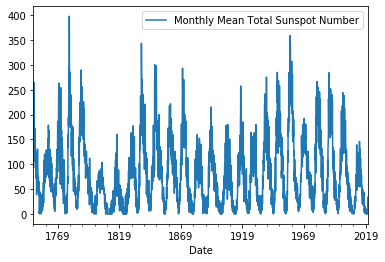

In [6]:
# Plot data
import pandas as pd
df.toPandas().plot.line(x="Date", y="Monthly Mean Total Sunspot Number")

In [4]:
# Feature engineering
# change timestamps to date, month, and year

from pyspark.sql.functions import *
df = df.withColumn("date_type", to_date("Date")).withColumn("month", month("date")).withColumn("year", year("date"))

In [5]:
# Feature engineering
# add dummy column for window function
df = df.withColumn("dummy", col("_c0") * 0)
df.show()

+---+-------------------+---------------------------------+----------+-----+----+-----+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|
+---+-------------------+---------------------------------+----------+-----+----+-----+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|
|  3|1749-04-30 00:00:00|                             92.8|1749-04-30|    4|1749|    0|
|  4|1749-05-31 00:00:00|                            141.7|1749-05-31|    5|1749|    0|
|  5|1749-06-30 00:00:00|                            139.2|1749-06-30|    6|1749|    0|
|  6|1749-07-31 00:00:00|                            158.0|1749-07-31|    7|1749|    0|
|  7|1749-08-31 00:00:00|                            110.5|1749-08-31|    8|1749|    0|
|  8|1749-09-30 00:00:00|       

In [9]:
# Feature Engineering
# include lag for 1, 5, and 11 years
window = Window.partitionBy("dummy").orderBy("_c0")

df_lag = df.withColumn("lag_1_year", lag("Monthly Mean Total Sunspot Number", 12).over(window)).withColumn("lag_5_year", lag("Monthly Mean Total Sunspot Number", 60).over(window)).withColumn("lag_11_year", lag("Monthly Mean Total Sunspot Number", 121).over(window))
df_lag.show(130)

+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|      null|      null|       null|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|      null|      null|       null|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|      null|      null|       null|
|  3|1749-04-30 00:00:00|                             92.8|1749-04-30|    4|1749|    0|      null|      null|       null|
|  4|1749-05-31 00:00:00|                            141.7|1749-05-31|    5|1749|    0|      null|      null|       null|
|  5|1749-06-30 00:00:00

In [10]:
# Feature Engineering
# Add moving average
window_avg_1 = Window.partitionBy("dummy").orderBy("_c0").rangeBetween(-12, 0)
window_avg_5 = Window.partitionBy("dummy").orderBy("_c0").rangeBetween(-60, 0)
window_avg_11 = Window.partitionBy("dummy").orderBy("_c0").rangeBetween(-121, 0)

df_final = df_lag.withColumn("avg_1_year", avg("Monthly Mean Total Sunspot Number").over(window_avg_1)).withColumn("avg_5_year", avg("Monthly Mean Total Sunspot Number").over(window_avg_5)).withColumn("avg_11_year", avg("Monthly Mean Total Sunspot Number").over(window_avg_11))
df_final.select("lag_1_year", "lag_5_year", "lag_11_year", "avg_1_year", "avg_5_year","avg_11_year").show()

+----------+----------+-----------+------------------+------------------+------------------+
|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|
+----------+----------+-----------+------------------+------------------+------------------+
|      null|      null|       null|              96.7|              96.7|              96.7|
|      null|      null|       null|             100.5|             100.5|             100.5|
|      null|      null|       null|105.89999999999999|105.89999999999999|105.89999999999999|
|      null|      null|       null|           102.625|           102.625|           102.625|
|      null|      null|       null|110.44000000000001|110.44000000000001|110.44000000000001|
|      null|      null|       null|115.23333333333335|115.23333333333335|115.23333333333335|
|      null|      null|       null|121.34285714285716|121.34285714285716|121.34285714285716|
|      null|      null|       null|119.98750000000001|119.987500000000

In [11]:
# Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder

feature_cols = ["month", "year", "lag_1_year", "lag_5_year", "lag_11_year", "avg_1_year", "avg_5_year", "avg_11_year"]

month_encoder = OneHotEncoder(inputCol="month", outputCol="MonthVector")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("keep")

In [12]:
# Train/test split
split_num = int(3265 * 0.7)
print("Splitting on", split_num)

# split the data based on time, not randomly
train = df_final.filter(df_final._c0 <=split_num)
test = df_final.filter(df_final._c0 > split_num)

train.show()

Splitting on 2285
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|      null|      null|       null|              96.7|              96.7|              96.7|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|      null|      null|       null|             100.5|             100.5|             100.5|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|

In [43]:
# Number of training samples
train.count()

2286

In [44]:
# Number of testing samples
test.count()

979

In [13]:
split_num = train.count() * 0.7
valid = train.filter(train._c0 > split_num)
train = train.filter(train._c0 <= split_num)

In [44]:
train.count()

1601

In [45]:
valid.count()

685

In [71]:
# Try replacing NULL values
first_sunspot = train.select("Monthly Mean Total Sunspot Number").first()[0]

train = train.fillna(first_sunspot, subset=["lag_1_year", "lag_5_year", "lag_11_year"])
train.show()

+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|      96.7|      96.7|       96.7|              96.7|              96.7|              96.7|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|      96.7|      96.7|       96.7|             100.5|             100.5|             100.5|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|      96.7|      9

In [16]:
from sparkdl.xgboost import XgboostRegressor

xgb = XgboostRegressor(num_workers=3, labelCol="Monthly Mean Total Sunspot Number")

pipeline = Pipeline(stages= [month_encoder, assembler, xgb])

xgb_model = pipeline.fit(train)

xgb_valid = rf_model.transform(valid)
xgb_valid.show()

ImportError: cannot import name 'resnet50' from 'keras.applications' (/opt/conda/anaconda/lib/python3.7/site-packages/keras/applications/__init__.py)

In [6]:
# Try implementing example code found here: https://medium.com/analytics-vidhya/time-series-forecasting-using-spark-ml-part-2-31506514c643
class LagGather:
# generates features for machine-learning
# previous time-step values are used as features
    def __init__(self):
        # this class has 2 data members
        self.nLags = 0
        self.FeatureNames = []
    def setLagLength(self, nLags):
        # this method sets the lag-length
        # if we want only previous time-step as feature
        # use lag-length = 1
        # if we want more lagged time-steps as features
        # set higher lag-length
        self.nLags = nLags
        return self
    def setInputCol(self, colname):
        #sets the input col for which features are generated
        # this identifies the univariate time-series on
        # which machine-learning and forecasting is done
        self.columnName = colname
        return self
    def transform(self, df):
        # transforms the spark dataframe and creates columns
        # that have time-lagged values
        # columns generated as used as features in ML
        df = df.withColumn("Series",lit('Univariate'))
        mywindow = Window.orderBy("Series")
        for i in range(self.nLags):
            strLag = self.columnName+'_LagBy_'+str(i+1)
            df = df.withColumn(strLag,lag(\
                               df[self.columnName], i+1).over(mywindow))
            self.FeatureNames.append(strLag)
        df = df.drop("Series")
        return df
    def getFeatureNames(self):
        # this return the names of feature-columns that are
        # generated by transform method
        return self.FeatureNames

In [16]:
# test out lag gather
lag = LagGather().setLagLength(nLags=12)
lag.setLagLength(12)
lag.setInputCol("date_type")
df_with_lag = lag.transform(df)
df_with_lag.show()

TypeError: 'LagGather' object is not callable

In [23]:
class MovingAverageSmoothing:
    # this class is used for performing Moving-average smoothing
    def __init__(self):
        # this class has 2 data members
        self.nLags= 0
        self.FeatureNames = []
        
    def setLagLength(self, nLags):
        # this sets the window size over which moving average is performed
        self.nLags = nLags
        return self
    
    def setInputCol(self, colname):
        #this sets the time-series column on which 
        #moving-average is performed
        self.columnName = colname
        return self
    
    def transform(self, df):
        # this transforms the spark dataframe (i.e time-series column)
        # and creates column contain the moving-average over created 
        # time-window
        mywindow = Window.rowsBetween(-self.nLags, 0)
        strMovAvg = self.columnName+'_'\
                    + str(self.nLags)+'_MovingAvg'
        df = df.withColumn(strMovAvg,\
                           avg(df[self.columnName]).over(mywindow))
        self.FeatureNames.append(strMovAvg)
        return df 
    
    def getFeatureNames(self):
        # this returns the name of feature-column 
        # created by transform method    
        return self.FeatureNames

In [24]:
class TrendGather:
    
    # this class is used to find trend in time-series data
    def __init__(self):
        # this has 2 data members
        self.nLags= 0 
        self.FeatureNames= []
        
    def setLagLength(self, nLags):
        # this sets the window-size over which trend is determined
        self.nLags = nLags
        return self
    
    def setInputCol(self, colname):
        # this sets the time-series column for which trend is to be
        # determined
        self.columnName = colname
        return self
    
    def transform(self, df):
        # this transforms the spark-dataframe (i.e. time-series column)
        # and generates column containing values +1, or -1 
        # if current value > time-lagged value then column-value = +1.0
        # if current value < time-lagged value then column-value = -1.0
        df = df.withColumn("Series",lit('Univariate'))       
        mywindow = Window.orderBy("Series")
        for i in range(self.nLags):
            strSign = self.columnName +'_Lag_'+str(i+1)+'_Sign'
            df = df.withColumn(strSign,\
                               signum((df[self.columnName] - \
                                       lag(df[self.columnName],i+1)\
                                       .over(mywindow))))
            self.FeatureNames.append(strSign)
        df = df.drop("Series")
        return df
    
    def getFeatureNames(self):
        # this returns name of feature generted by transform method
        return self.FeatureNames

In [25]:
def Difference(df, inputCol, outputCol):
    # performs first-order differencing
    lag1Window = Window.rowsBetween(-1, 0)
    #df = df.withColumn(outputCol, \
    #                   df[inputCol] -  func.first(df[inputCol]).over(lag1Window))
    df = df.withColumn(outputCol, round(months_between(df[inputCol], func.first(df[inputCol]).over(lag1Window))))
    return df

In [26]:
def Forecast(df, forecast_days, nLags,timeSeriesColumn, regressor, sparksession):
 
    # this performs model training
    # this calls the machine-learning algorithms of Spark ML library
    #creating labels for machine-learning
    LeadWindow = Window.rowsBetween(0,forecast_days)   
    df = df.withColumn("label",func.last(df[timeSeriesColumn]).over(LeadWindow))
    
    features = [timeSeriesColumn]
    
    #Auto-regression feature
    LagTransformer = LagGather()\
                     .setLagLength(nLags)\
                     .setInputCol(timeSeriesColumn)
    df = LagTransformer.transform(df)
    featuresGenerated = LagTransformer.getFeatureNames()
    features.extend(featuresGenerated)
    
    #Other feature generators here:
    #Moving Average Smoothing
    #TrendGather
    # VECTOR ASSEMBLER
    # this assembles the all the features
    df = df.dropna()
    vA = VectorAssembler().setInputCols(features)\
                          .setOutputCol("features")
    df_m = vA.transform(df)
    # Splitting data into train, test
    splitratio = 0.7
    df_train, df_test = TimeSeriesSplit(df_m, splitratio, sparksession)
    # DECISION-TREE REGRESSOR
    if(regressor == "DecisionTreeRegression"):
           
        dr = DecisionTreeRegressor(featuresCol = "features",\
                                   labelCol = "label", maxDepth = 5)
        model = dr.fit(df_train)
        predictions_dr_test = model.transform(df_test)
        predictions_dr_train = model.transform(df_train)
        # RMSE is used as evaluation metric        
        evaluator = RegressionEvaluator(predictionCol="prediction",\
                                        labelCol="label",\
                                        metricName ="rmse")
        RMSE_dr_test = evaluator.evaluate(predictions_dr_test)
        RMSE_dr_train = evaluator.evaluate(predictions_dr_train)
        return (df_test, df_train, \
                predictions_dr_test, predictions_dr_train,\
                RMSE_dr_test, RMSE_dr_train)
    # LINEAR REGRESSOR
    if(regressor == 'LinearRegression'):
        lr = LinearRegression(featuresCol = "features", labelCol="label", \
                              maxIter = 100, regParam = 0.4, \
                              elasticNetParam = 0.1)
        model = lr.fit(df_train)
        predictions_lr_test = model.transform(df_test)
        predictions_lr_train = model.transform(df_train)
        
        # RMSE is used as evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction",\
                                        labelCol="label",\
                                        metricName ="rmse")
        RMSE_lr_test= evaluator.evaluate(predictions_lr_test)
        RMSE_lr_train = evaluator.evaluate(predictions_lr_train)
        return (df_test, df_train, \
                predictions_lr_test, predictions_lr_train,\
                RMSE_lr_test, RMSE_lr_train)
    
    # RANDOM FOREST REGRESSOR
    if(regressor == 'RandomForestRegression'):
        rfr = RandomForestRegressor(featuresCol="features",\
                                    labelCol="label",\
                                    maxDepth = 5,\
                                    subsamplingRate = 0.8,\
                                    )
        model = rfr.fit(df_train)
        predictions_rfr_test = model.transform(df_test)
        predictions_rfr_train = model.transform(df_train)
        
        # RMSE is used as evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction",\
                                        labelCol="label",\
                                        metricName ="rmse")
        RMSE_rfr_test= evaluator.evaluate(predictions_rfr_test)
        RMSE_rfr_train = evaluator.evaluate(predictions_rfr_train)
        return (df_test, df_train, \
                predictions_rfr_test, predictions_rfr_train,\
                RMSE_rfr_test, RMSE_rfr_train)
    
    # GRADIENT BOOSTING TREE REGRESSOR
    if(regressor == 'GBTRegression'):
        gbt = GBTRegressor(featuresCol="features",\
                           labelCol="label",\
                           maxDepth=5,\
                           subsamplingRate=0.8)
        
        model = gbt.fit(df_train)
        predictions_gbt_test = model.transform(df_test)
        predictions_gbt_train = model.transform(df_train)
        
        # RMSE is used as evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction",\
                                        labelCol="label",\
                                        metricName ="rmse")
        RMSE_gbt_test= evaluator.evaluate(predictions_gbt_test)
        RMSE_gbt_train = evaluator.evaluate(predictions_gbt_train)
        return (df_test, df_train,predictions_gbt_test, predictions_gbt_train,RMSE_gbt_test, RMSE_gbt_train)

In [27]:
def TimeSeriesSplit(df_m, splitRatio, sparksession):
     
    # Splitting data into train and test
    # we maintain the time-order while splitting
    # if split ratio = 0.7 then first 70% of data is train data
    # and remaining 30% of data is test data
    newSchema  = StructType(df_m.schema.fields + \
                [StructField("Row Number", LongType(), False)])
    new_rdd = df_m.rdd.zipWithIndex().map(lambda x: list(x[0]) + [x[1]])
    df_m2 = sparksession.createDataFrame(new_rdd, newSchema)
    total_rows = df_m2.count()
    splitFraction  =int(total_rows*splitRatio)
    df_train = df_m2.where(df_m2["Row Number"] >= 0)\
                   .where(df_m2["Row Number"] <= splitFraction)
    df_test = df_m2.where(df_m2["Row Number"] > splitFraction)
    
    return df_train, df_test

In [28]:
def CheckStationarity(timeSeriesCol):
    
    # this function works with Pandas dataframe only not with spark dataframes
    # this performs Augmented Dickey-Fuller's test
    
    test_result = adfuller(timeSeriesCol.values)
    print("ADF Statistic : %f \n" %test_result[0])
    print("p-value : %f \n" %test_result[1])
    print("Critical values are: \n")
    print(test_result[4])

In [77]:
def Predict(i, df1, df2, timeSeriesCol, predictionCol, joinCol):
    
    # this converts differenced predictions to raw predictions
    dZCol = "DeltaZ"+str(i) 
    f_strCol = 'forecast_'+str(i)+'day'

    df = df1.join(df2.withColumnRenamed(timeSeriesCol,"date_type_2"), [joinCol], how='inner')\
                            .orderBy(asc(timeSeriesCol))
    df = df.withColumnRenamed(predictionCol, dZCol)
    df = df.select(col("Row Number"),col(timeSeriesCol).alias("timeSeries"), col(dZCol).alias("dz")).withColumn(f_strCol, expr("add_months(timeSeries,dz)"))
    df = df.withColumnRenamed("timeSeries", timeSeriesCol)
    return df

In [80]:
def SavePredictions(df,
regressionType,\
forecast_days, \
feature_nLags,\
filename, \
sparksession, timeSeriesCol="date_type"):

    # this is the main function which calls forecast and predict
    # this saves predictions in csv files

    #Differencing data to remove non-stationarity
    diff_timeSeriesCol = "Diff_"+timeSeriesCol
    df = Difference(df, timeSeriesCol,diff_timeSeriesCol)

    RMSE_test = {}
    RMSE_train = {}

    #Forecasting and Undifferencing the data
    for i in range(1, forecast_days+1):

        # training with Spark's ML algorithms    
        df_test, df_train, \
        predictions_test, predictions_train,\
        RMSE_ts, RMSE_tr = \
        Forecast(df.select(timeSeriesCol,diff_timeSeriesCol),\
        i, feature_nLags, \
        diff_timeSeriesCol,regressionType, sparksession)
        RMSE_test.update({'forecast_'+str(i)+'day':RMSE_ts})
        RMSE_train.update({'forecast_'+str(i)+'day':RMSE_tr})
    #predictions for training data            
        if(i == 1):

            #saving the 1-day forecast as separate column
            corr_predict_train = Predict(i, 
            df_train.select("Row Number",
            "date_type",\
            timeSeriesCol),\
            predictions_train.select("Row Number",\
            "prediction"),
            timeSeriesCol,\
            "prediction",\
            "Row Number")

            corr_predict_test = Predict(i, \
            df_test.select("Row Number",\
            "date_type",\
            timeSeriesCol),\
            predictions_test.select("Row Number",\
            "prediction"),
            timeSeriesCol,\
            "prediction",\
            "Row Number") 
        else:
            # saving each subsequent forecast as separate column
            strCol_prev= "forecast_" + str(i-1) + "day"
            corr_predict_train = Predict(i, \
            corr_predict_train,\
            predictions_train.select("Row Number",\
            "prediction"),\
            strCol_prev,\
            "prediction",\
            "Row Number")
            corr_predict_test = Predict(i, \
            corr_predict_test,\
            predictions_test.select("Row Number",\
            "prediction"),\
            strCol_prev,\
            "prediction",\
            "Row Number")
        
        # saving actual labels as separate columns
        LeadWindow = Window.rowsBetween(0, i)    
        a_strCol = "actual_"+str(i)+"day"
        corr_predict_test = corr_predict_test.withColumn(a_strCol,func.last(corr_predict_test[timeSeriesCol]).over(LeadWindow))
        corr_predict_train = corr_predict_train.withColumn(a_strCol,func.last(corr_predict_train[timeSeriesCol]).over(LeadWindow))
    # Saving data into csv files
    corr_predict_test.write.format("csv").option("header","true")\
    .save(filename+"test.csv")
    corr_predict_train.write.format("csv").option("header","true")\
    .save(filename+"train.csv") 

    #error statistics summary  
    print("Error statistics summary for %s " %(filename))
    print("RMSE for train data:\n")
    print(RMSE_train)
    print("RMSE for test data:\n")
    print(RMSE_test)
    print('Two output files created')
    print('Predictions for train data: %s' %(filename+'train.csv'))
    print('Predictions for test data: %s' %(filename +'test.csv'))
    return RMSE_train, RMSE_test

In [8]:
from pyspark.sql import Window
from pyspark.sql.functions import col, asc, desc, to_timestamp,\
                                  unix_timestamp, from_unixtime
from pyspark.sql.types import StructType, StructField, LongType
import pyspark.sql.functions as func
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [81]:
RMSE_train_df = pd.DataFrame()
RMSE_test_df = pd.DataFrame()

timeSeriesCol = "date_type"
regressionType = "LinearRegression"
forecast_days = 5
num_lags = 3

RMSE_train, RMSE_test = SavePredictions(df,regressionType,forecast_days,num_lags,"LR_Predictions",spark)
RMSE_train_df = RMSE_train_df.append(RMSE_train, ignore_index = True) 
RMSE_test_df = RMSE_test_df.append(RMSE_test, ignore_index = True)

AnalysisException: 'Cannot resolve column name "date_type" among (Row Number, forecast_1day, dz, forecast_2day);'